In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import userdata
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df = pd.read_csv('/content/Updated_dataset_with_full_text.csv')

In [ ]:
df

,TweetID,Username,CreateDate,Biased,Keyword,Text
0,1232258532273090560,amit2nirvana,2020-02-25 10:58:23+00:00,0,Israel,The last 24 hours in Israel: https://t.co/0YNw...
1,1224025761092448257,NinjaAlex420,2020-02-02 17:44:17+00:00,0,Israel,@stranahan KnowMoreNews isn't confident enough...
2,1242382710561107969,SevenShepherd,2020-03-24 09:28:15+00:00,0,Israel,"""[Even] an heritage unto Israel his servant: f..."
3,1224677205306818561,MGSheikh8,2020-02-04 12:52:53+00:00,0,Israel,Opinion: No One in Israel Knew They Were Commi...
4,1214278369338109953,elianebis1,2020-01-06 20:11:38+00:00,0,Israel,https://t.co/LTB0zidzM9 When #TheCloudOfGod ap...
...,...,...,...,...,...,...
6936,1255850426899013632,TAG73957257,2020-04-30 13:24:09+00:00,1,ZioNazi,@JackieKane I'd never go back. ZioNazi managem...
6937,1234276923213303812,totalsatire,2020-03-02 00:38:44+00:00,1,ZioNazi,@JulianRoepcke The lovely Zionazi Djihad Julia...
6938,1240883925096030208,Futatimbo,2020-03-20 06:12:36+00:00,1,ZioNazi,@IvankaTrump A zionazists Jews.
6939,1241091821645844480,Futatimbo,2020-03-20 19:58:43+00:00,1,ZioNazi,"Mr. President, I this year you will lead the I..."


In [ ]:
# # prompt: delete half of rows where Biased = 0

# df = df.drop(df.loc[df['Biased'] == 0].sample(frac=0.5).index)
# df


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6941 entries, 0 to 6940
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   TweetID     6941 non-null   int64 
 1   Username    6941 non-null   object
 2   CreateDate  6941 non-null   object
 3   Biased      6941 non-null   int64 
 4   Keyword     6941 non-null   object
 5   Text        6941 non-null   object
dtypes: int64(2), object(4)
memory usage: 325.5+ KB


In [ ]:
df.isnull().sum()

TweetID       0
Username      0
CreateDate    0
Biased        0
Keyword       0
Text          0
dtype: int64

In [ ]:
df.duplicated().sum()

3

In [ ]:
df[df.duplicated()]

,TweetID,Username,CreateDate,Biased,Keyword,Text
1880,1217862006981742593,illrev2,2020-01-16 17:31:43+00:00,0,Jews,@AndyWalker1963 @KeloidKrown @clarkegeorgina1 ...
2321,1283401552032456705,thaatDogFather,2020-07-15 14:02:29+00:00,0,Jews,@LuvLife289 @alanamikia He called Jews “roache...
6237,1287911401906872320,pmjp123,2020-07-28 00:43:01+00:00,0,Jews,"Dear Jews, Hindus are your fiercest allies b..."


In [ ]:
df = df.drop_duplicates()

In [ ]:
# Drop columns: 'TweetID', 'Username' and 2 other columns
df = df.drop(columns=['TweetID', 'Username', 'CreateDate', 'Keyword'])

In [ ]:
df

,Biased,Text
0,0,The last 24 hours in Israel: https://t.co/0YNw...
1,0,@stranahan KnowMoreNews isn't confident enough...
2,0,"""[Even] an heritage unto Israel his servant: f..."
3,0,Opinion: No One in Israel Knew They Were Commi...
4,0,https://t.co/LTB0zidzM9 When #TheCloudOfGod ap...
...,...,...
6936,1,@JackieKane I'd never go back. ZioNazi managem...
6937,1,@JulianRoepcke The lovely Zionazi Djihad Julia...
6938,1,@IvankaTrump A zionazists Jews.
6939,1,"Mr. President, I this year you will lead the I..."


In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
def simple_preprocessing(df):

  lemmatizer = WordNetLemmatizer()

  processed_text = []
  for review in df['Text']:
    # Lowercase the text
    review = review.lower()

    # Remove HTML tags
    review = re.sub(r'<.*?>', '', review)

    # Remove urls
    review = re.sub(r'http\S+', '', review)

    # Remove hashtags and @ symbols
    review = re.sub(r'#', '', review)
    review = re.sub(r'@', '', review)


    # Tokenize the text
    tokens = word_tokenize(review)

    # Remove punctuation
    tokens = [token for token in tokens if token.isalpha()]

    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]


    #tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a string
    processed_text.append(' '.join(tokens))

  return processed_text

In [ ]:
preprocessed_df = df.copy()

In [ ]:
preprocessed_df['Text'] = simple_preprocessing(preprocessed_df)

In [ ]:
preprocessed_df

,Biased,Text
0,0,last hours israel
1,0,stranahan knowmorenews confident enough debate...
2,0,even heritage unto israel servant mercy endure...
3,0,opinion one israel knew committing massacre
4,0,thecloudofgod appeared days moses took childre...
...,...,...
6936,1,jackiekane never go back zionazi management
6937,1,julianroepcke lovely zionazi djihad julian als...
6938,1,ivankatrump zionazists jews
6939,1,president year lead iranian nation build nucle...


In [ ]:
def stemming(df):
  stemmer = PorterStemmer()
  df['Text'] = df['Text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
  return df

In [ ]:
stemmed_df = stemming(preprocessed_df)

In [ ]:
stemmed_df

,Biased,Text
0,0,last hour israel
1,0,stranahan knowmorenew confid enough debat jesu...
2,0,even heritag unto israel servant merci enduret...
3,0,opinion one israel knew commit massacr
4,0,thecloudofgod appear day mose took children is...
...,...,...
6936,1,jackiekan never go back zionazi manag
6937,1,julianroepck love zionazi djihad julian also w...
6938,1,ivankatrump zionazist jew
6939,1,presid year lead iranian nation build nuclear ...


In [ ]:
stemmed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6938 entries, 0 to 6940
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Biased  6938 non-null   int64 
 1   Text    6938 non-null   object
dtypes: int64(1), object(1)
memory usage: 162.6+ KB


In [ ]:
df2 = pd.read_csv("/content/for_model_analysed_df_15_05_24_with_countries copy.csv")

In [ ]:
df2 = df2.rename(columns={'text': 'Text'})
df2 = df2.rename(columns={'antisemitic_post': 'Biased'})

In [ ]:
df2

,Text,Biased
0,We Are Palestine! https://t.co/iKBFWdnTKD,1
1,Thousands of people took part in a mass rally ...,0
2,#Apartheidisrael silencing journalists \nOccu...,1
3,A list of Joe Biden’s trips he has taken since...,0
4,This is Gaza right now. Victims are not blue-e...,1
...,...,...
1654,"🧵 1/3 Today, I attempted to compel the State D...",1
1655,I’m a scholar of the Israeli-Palestinian confl...,0
1656,New CNN poll\n\nBiden approval of handling of ...,0
1657,“I don’t think that people think Israel is a u...,1


In [ ]:
df2['Text'] = simple_preprocessing(df2)

In [ ]:
df2_stemmed = stemming(df2)

In [ ]:
# add df2_stemmed to the stemmed_df

stemmed_df = pd.concat([stemmed_df, df2_stemmed])


In [ ]:
stemmed_df

,Biased,Text
0,0,last hour israel
1,0,stranahan knowmorenew confid enough debat jesu...
2,0,even heritag unto israel servant merci enduret...
3,0,opinion one israel knew commit massacr
4,0,thecloudofgod appear day mose took children is...
...,...,...
1654,1,today attempt compel state dept end big lie fu...
1655,0,scholar conflict longtim advoc peac palestinia...
1656,0,new cnn poll biden approv handl war among year...
1657,1,think peopl think israel uniqu exampl evil wor...


In [ ]:
X = stemmed_df['Text']
y = stemmed_df['Biased']

In [ ]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)
X_tfidf.shape

(8597, 14655)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6877, 14655)
(6877,)
(1720, 14655)
(1720,)


In [ ]:
# import the LogisticRegression model from sklearn
# import accuracy_score, classification_report, confusion_matrix from sklearn.metrics

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Instantiate the LogisticRegression model.
model = LogisticRegression()

# Fit the model on the training data.
model.fit(X_train, y_train)

# Predict on the test data.
y_pred = model.predict(X_test)

# Evaluate the model.
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8273255813953488
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1281
           1       0.80      0.43      0.56       439

    accuracy                           0.83      1720
   macro avg       0.82      0.70      0.73      1720
weighted avg       0.82      0.83      0.81      1720

[[1235   46]
 [ 251  188]]


In [ ]:
tweets = ["i catched a fish from the river", "i went to the sea today and saw a lot of pretty people out there"]

# Convert the reviews to TF-IDF vectors
X_tfidf = vectorizer.transform(tweets)

# Predict the sentiment of the reviews
y_pred = model.predict(X_tfidf)

# Print the predicted sentiment
for text, biased in zip(tweets, y_pred):
  if biased == 1:
    print(f" {text}: antisemitic")
  else:
    print(f" {text}:  non-antisemitic")


 i catched a fish from the river:  non-antisemitic
 i went to the sea today and saw a lot of pretty people out there:  non-antisemitic


In [ ]:
tweets = ["from the river to the sea palestine will be free"]

# Convert the reviews to TF-IDF vectors
X_tfidf = vectorizer.transform(tweets)

# Predict the sentiment of the reviews
y_pred = model.predict(X_tfidf)

# Print the predicted sentiment
for text, biased in zip(tweets, y_pred):
  if biased == 1:
    print(f" {text}: antisemitic")
  else:
    print(f" {text}:  non-antisemitic")


 from the river to the sea palestine will be free: antisemitic


In [ ]:
def predict_sent(tweet):
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
    # Lowercase the text
  # tweet = tweet.lower()

  # # Remove HTML tags
  # tweet = re.sub(r'<.*?>', '', tweet)

  # # Remove urls
  # tweet = re.sub(r'http\S+', '', tweet)

  # # Remove hashtags and @ symbols
  # tweet = re.sub(r'#', '', tweet)
  # tweet = re.sub(r'@', '', tweet)



  # # Tokenize the text
  # tokens = word_tokenize(tweet)

  # # Remove punctuation
  # tokens = [token for token in tokens if token.isalpha()]

  # # Remove stop words
  # tokens = [token for token in tokens if token not in stop_words]


  # tokens = [lemmatizer.lemmatize(token) for token in tokens]

  # tokens = [stemmer.stem(token) for token in tokens ]

  # tweet = ' '.join(tokens)

  # Convert the review to TF-IDF vectors
  X_tfidf = vectorizer.transform([tweet])

  # Predict the sentiment of the review
  prediction = model.predict(X_tfidf)[0]

  # Print the predicted sentiment
  if prediction == 1:
    return f" {tweet}: The tweet is antisemitic"
  else:
    return f" {tweet}: The tweet is non-antisemitic"




In [ ]:
tweet = 'jews run the world'
predict_sent(tweet)

' jews run the world: The tweet is antisemitic'

In [ ]:
def predict_text2(tweet):
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
    # Lowercase the text
  tweet = tweet.lower()

  # Remove HTML tags
  tweet = re.sub(r'<.*?>', '', tweet)

  # Remove urls
  tweet = re.sub(r'http\S+', '', tweet)

  # Remove hashtags and @ symbols
  tweet = re.sub(r'#', '', tweet)
  tweet = re.sub(r'@', '', tweet)



  # Tokenize the text
  tokens = word_tokenize(tweet)

  # Remove punctuation
  tokens = [token for token in tokens if token.isalpha()]

  # Remove stop words
  tokens = [token for token in tokens if token not in stop_words]

  #tokens = [lemmatizer.lemmatize(token) for token in tokens]

  tokens = [stemmer.stem(token) for token in tokens ]

  tweet = ' '.join(tokens)

  # Convert the review to TF-IDF vectors
  X_tfidf = vectorizer.transform([tweet])

  # Predict the sentiment of the review
  prediction = model.predict(X_tfidf)[0]


  return prediction



In [ ]:
testing_df = pd.read_csv("/content/analysed_df_15_05_24_with_countries.csv")

In [ ]:
testing_df

,Unnamed: 0,type,date,url,text,user,user_url,user_location,followers,following,account_creation_date,tweet_likes,quotes,retweets,antisemitic_post,country
0,0,tweet,2023-04-16 15:15:51+00:00,https://twitter.com/WeArePalestine3/status/164...,We Are Palestine! https://t.co/iKBFWdnTKD,WeArePalestine3,https://x.com/WeArePalestine3,Ramallah,7155,3728,21/02/2023,3838,32,1244,True,Palestine
1,1,tweet,2023-04-12 17:41:21+00:00,https://twitter.com/Sprinterfactory/status/164...,Thousands of people took part in a mass rally ...,Sprinterfactory,https://x.com/Sprinterfactory,💞💞💞,548778,958,14/05/2019,10240,189,4889,False,Unknown
2,2,tweet,2023-04-29 20:30:55+00:00,https://twitter.com/Bsonja5/status/16524101539...,#Apartheidisrael silencing journalists \nOccu...,Bsonja5,https://x.com/Bsonja5,NaN,8411,529,11/05/2012,1212,88,1459,True,Unknown
3,3,tweet,2023-04-11 16:33:14+00:00,https://twitter.com/KCPayTreeIt/status/1645827...,A list of Joe Biden’s trips he has taken since...,KCPayTreeIt,https://x.com/KCPayTreeIt,KC,53166,17445,07/07/2022,1182,31,759,False,Unknown
4,4,tweet,2023-04-06 22:45:10+00:00,https://twitter.com/imMAK02/status/16441090157...,This is Gaza right now. Victims are not blue-e...,imMAK02,https://x.com/imMAK02,India,93489,155,09/04/2011,3909,87,2374,True,India
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,1683,tweet,2024-04-29 23:44:57+00:00,https://twitter.com/samhusseini/status/1785092...,"🧵 1/3 Today, I attempted to compel the State D...",samhusseini,https://x.com/samhusseini,Anti-DC,65109,8871,12/02/2009,6954,38,1884,True,Unknown
1655,1684,tweet,2024-04-28 00:00:31+00:00,https://twitter.com/DovWaxman/status/178437208...,I’m a scholar of the Israeli-Palestinian confl...,DovWaxman,https://x.com/DovWaxman,"Los Angeles, CA",12640,1185,14/06/2011,10098,533,2074,False,United States of America
1656,1685,tweet,2024-04-28 12:34:32+00:00,https://twitter.com/umichvoter/status/17845618...,New CNN poll\n\nBiden approval of handling of ...,umichvoter,https://x.com/umichvoter,NaN,54048,1717,12/06/2020,14966,395,1960,False,Unknown
1657,1686,tweet,2024-04-29 04:46:16+00:00,https://twitter.com/davidminpdx/status/1784806...,“I don’t think that people think Israel is a u...,davidminpdx,https://x.com/davidminpdx,"Portland, Oregon",25870,1966,30/03/2012,9485,17,1667,True,United States of America


In [ ]:
# create month_year column from date

testing_df['month_year'] = pd.to_datetime(testing_df['date']).dt.strftime('%Y-%m')


# change true false in column antisemitic_post to 1 and 0

testing_df['antisemitic_post'] = testing_df['antisemitic_post'].apply(lambda x: 1 if x == True else 0)



In [ ]:
# # delete random rows in each month_year from testing_df to make every month_year have same count of posts

# import random

# # Define the desired number of posts per month_year
# desired_posts_per_month_year = 100

# # Create a dictionary to store the indices of rows to delete
# rows_to_delete = {}

# # Loop through each month_year
# for month_year in testing_df['month_year'].unique():
#   # Get the indices of rows in the current month_year
#   month_year_indices = testing_df[testing_df['month_year'] == month_year].index.tolist()

#   # Calculate the number of rows to delete to achieve the desired count
#   num_rows_to_delete = len(month_year_indices) - desired_posts_per_month_year

#   # Randomly select rows to delete
#   random_indices_to_delete = random.sample(month_year_indices, num_rows_to_delete)

#   # Store the indices in the dictionary
#   rows_to_delete[month_year] = random_indices_to_delete

# # Delete the rows from the DataFrame
# for month_year, indices in rows_to_delete.items():
#   testing_df = testing_df.drop(indices)

# # Verify that each month_year has the desired number of posts
# for month_year in testing_df['month_year'].unique():
#   assert len(testing_df[testing_df['month_year'] == month_year]) == desired_posts_per_month_year



In [ ]:
testing_df['month_year'].unique()

array(['2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
       '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03',
       '2024-04'], dtype=object)

In [ ]:
testing_df

,Unnamed: 0,type,date,url,text,user,user_url,user_location,followers,following,account_creation_date,tweet_likes,quotes,retweets,antisemitic_post,country,month_year
0,0,tweet,2023-04-16 15:15:51+00:00,https://twitter.com/WeArePalestine3/status/164...,We Are Palestine! https://t.co/iKBFWdnTKD,WeArePalestine3,https://x.com/WeArePalestine3,Ramallah,7155,3728,21/02/2023,3838,32,1244,1,Palestine,2023-04
1,1,tweet,2023-04-12 17:41:21+00:00,https://twitter.com/Sprinterfactory/status/164...,Thousands of people took part in a mass rally ...,Sprinterfactory,https://x.com/Sprinterfactory,💞💞💞,548778,958,14/05/2019,10240,189,4889,0,Unknown,2023-04
2,2,tweet,2023-04-29 20:30:55+00:00,https://twitter.com/Bsonja5/status/16524101539...,#Apartheidisrael silencing journalists \nOccu...,Bsonja5,https://x.com/Bsonja5,NaN,8411,529,11/05/2012,1212,88,1459,1,Unknown,2023-04
3,3,tweet,2023-04-11 16:33:14+00:00,https://twitter.com/KCPayTreeIt/status/1645827...,A list of Joe Biden’s trips he has taken since...,KCPayTreeIt,https://x.com/KCPayTreeIt,KC,53166,17445,07/07/2022,1182,31,759,0,Unknown,2023-04
4,4,tweet,2023-04-06 22:45:10+00:00,https://twitter.com/imMAK02/status/16441090157...,This is Gaza right now. Victims are not blue-e...,imMAK02,https://x.com/imMAK02,India,93489,155,09/04/2011,3909,87,2374,1,India,2023-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,1683,tweet,2024-04-29 23:44:57+00:00,https://twitter.com/samhusseini/status/1785092...,"🧵 1/3 Today, I attempted to compel the State D...",samhusseini,https://x.com/samhusseini,Anti-DC,65109,8871,12/02/2009,6954,38,1884,1,Unknown,2024-04
1655,1684,tweet,2024-04-28 00:00:31+00:00,https://twitter.com/DovWaxman/status/178437208...,I’m a scholar of the Israeli-Palestinian confl...,DovWaxman,https://x.com/DovWaxman,"Los Angeles, CA",12640,1185,14/06/2011,10098,533,2074,0,United States of America,2024-04
1656,1685,tweet,2024-04-28 12:34:32+00:00,https://twitter.com/umichvoter/status/17845618...,New CNN poll\n\nBiden approval of handling of ...,umichvoter,https://x.com/umichvoter,NaN,54048,1717,12/06/2020,14966,395,1960,0,Unknown,2024-04
1657,1686,tweet,2024-04-29 04:46:16+00:00,https://twitter.com/davidminpdx/status/1784806...,“I don’t think that people think Israel is a u...,davidminpdx,https://x.com/davidminpdx,"Portland, Oregon",25870,1966,30/03/2012,9485,17,1667,1,United States of America,2024-04


In [ ]:
# prompt: Используется DataFrame testing_df: show text column and  antisemitic_post with 2023-10 in month_year column

testing_df[testing_df['month_year'].str.contains('2023-10')][['text', 'antisemitic_post']]

,text,antisemitic_post
744,"China has removed Israel from its online maps,...",0
745,"The Nakba, 1948\n700000 Palestinians expelled,...",1
746,“Is Gaza this scary for them? I am so proud to...,1
747,Republicans in the House refuse to fund Israel...,0
748,"Thank you, thank you, thank you. \n\nThank you...",0
...,...,...
857,"Former British PM @BorisJohnson: ""We've got to...",0
858,Remember how the CIA funded NAFO to spam the I...,1
859,Israel claims that Gaza's Al-Shifa hospital se...,0
860,Making it easier for rich people to cheat on t...,0


In [ ]:
# Group by month_year and count the number of posts
grouped_df = testing_df.groupby('month_year')['antisemitic_post'].count().reset_index()

# Print the grouped DataFrame
print(grouped_df)


   month_year  antisemitic_post
0     2023-04               133
1     2023-05               118
2     2023-06               117
3     2023-07               134
4     2023-08               111
5     2023-09               131
6     2023-10               118
7     2023-11               134
8     2023-12               132
9     2024-01               132
10    2024-02               135
11    2024-03               132
12    2024-04               132


In [ ]:
# apply function predict_sent to every text in dataframe  testing_df  and put the output in column "test_model"

testing_df['test_antisemitic_post'] = testing_df['text'].apply(predict_text2)


In [ ]:
# compare columns antisemitic_post and  test_antisemitic_post on accuracy

from sklearn.metrics import accuracy_score

# Get the accuracy of the model predictions
accuracy = accuracy_score(testing_df['antisemitic_post'], testing_df['test_antisemitic_post'])

# Print the accuracy
print("Accuracy:", accuracy)


Accuracy: 0.7281494876431586


In [ ]:
#Calculate percentage by country with chatGPT analysis

# Calculate the counts of each country
location_counts = testing_df['country'].value_counts()

# Filter the DataFrame based on user locations that occur more than 10 times
df_analysed_over_10_loc = testing_df[testing_df['country'].isin(location_counts[location_counts > 5].index)]

antisemitic_count = df_analysed_over_10_loc.groupby('country')['antisemitic_post'].sum()
total_count = df_analysed_over_10_loc.groupby('country')['antisemitic_post'].count()
percentage_df = pd.DataFrame({'Country': antisemitic_count.index, 'Total_posts': total_count, 'Antisemitic_posts': antisemitic_count, 'Percentage': antisemitic_count / total_count * 100})
percentage_df


,Country,Total_posts,Antisemitic_posts,Percentage
country,,,,
Australia,Australia,14,10,71.428571
Canada,Canada,9,6,66.666667
Denmark,Denmark,29,19,65.517241
Germany,Germany,6,6,100.000000
Greece,Greece,10,9,90.000000
India,India,14,4,28.571429
Iran,Iran,8,8,100.000000
Ireland,Ireland,17,11,64.705882
Israel,Israel,66,9,13.636364


In [ ]:
#Calculate percentage by country with our model analysis

# Calculate the counts of each country
location_counts = testing_df['country'].value_counts()

# Filter the DataFrame based on user locations that occur more than 10 times
df_analysed_over_10_loc = testing_df[testing_df['country'].isin(location_counts[location_counts > 5].index)]

antisemitic_count = df_analysed_over_10_loc.groupby('country')['test_antisemitic_post'].sum()
total_count = df_analysed_over_10_loc.groupby('country')['test_antisemitic_post'].count()
percentage_df = pd.DataFrame({'Country': antisemitic_count.index ,'Total_posts': total_count, 'Antisemitic_posts': antisemitic_count, 'Percentage': antisemitic_count / total_count * 100})
percentage_df

,Country,Total_posts,Antisemitic_posts,Percentage
country,,,,
Australia,Australia,14,5,35.714286
Canada,Canada,9,5,55.555556
Denmark,Denmark,29,11,37.931034
Germany,Germany,6,5,83.333333
Greece,Greece,10,4,40.000000
India,India,14,2,14.285714
Iran,Iran,8,6,75.000000
Ireland,Ireland,17,7,41.176471
Israel,Israel,66,4,6.060606


In [ ]:
filtered_grouped_df = percentage_df[percentage_df['Country'] != 'Unknown'].copy()

In [ ]:
filtered_grouped_df

,Country,Total_posts,Antisemitic_posts,Percentage
country,,,,
Australia,Australia,14,5,35.714286
Canada,Canada,9,5,55.555556
Denmark,Denmark,29,11,37.931034
Germany,Germany,6,5,83.333333
Greece,Greece,10,4,40.000000
India,India,14,2,14.285714
Iran,Iran,8,6,75.000000
Ireland,Ireland,17,7,41.176471
Israel,Israel,66,4,6.060606


In [ ]:
graph_data = filtered_grouped_df[['Country','Percentage']]

<Figure size 1000x600 with 0 Axes>

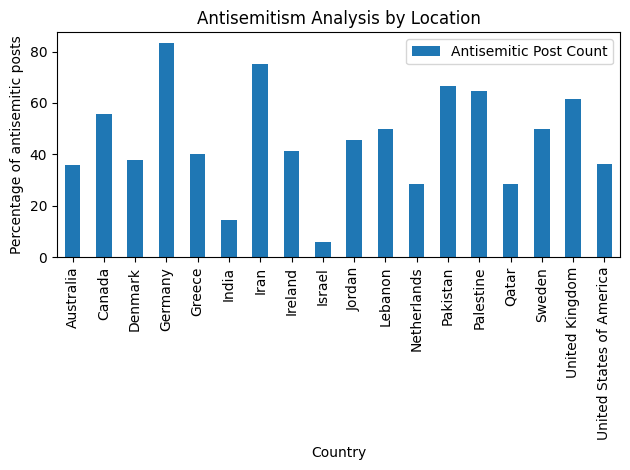

In [ ]:
plt.figure(figsize=(10, 6))
graph_data.plot(kind="bar", stacked=True)
plt.title("Antisemitism Analysis by Location")
plt.xlabel("Country")
plt.ylabel("Percentage of antisemitic posts")
plt.xticks(rotation=90)
# Set country names as x-axis labels
plt.xticks(range(len(filtered_grouped_df.index)), filtered_grouped_df['Country'])
plt.legend(["Antisemitic Post Count", "Non-Antisemitic Post Count"])
plt.tight_layout()
plt.show()

In [ ]:
antisemitic_tweets_by_user = testing_df.groupby(['user','user_url'])[['test_antisemitic_post']].sum().reset_index()

In [ ]:
# sort antisemitic_tweets_by_user by test_antisemitic_post

antisemitic_tweets_by_user = antisemitic_tweets_by_user.sort_values(by=['test_antisemitic_post'], ascending=False)


In [ ]:
antisemitic_tweets_by_user

,user,user_url,test_antisemitic_post
670,jacksonhinklle,https://x.com/jacksonhinklle,35
350,QudsNen,https://x.com/QudsNen,21
798,sahouraxo,https://x.com/sahouraxo,15
117,DrLoupis,https://x.com/DrLoupis,11
333,PalestineCultu1,https://x.com/PalestineCultu1,11
...,...,...,...
493,WesleyHuntTX,https://x.com/WesleyHuntTX,0
204,JehadAbusalim,https://x.com/JehadAbusalim,0
205,JeremyWard33,https://x.com/JeremyWard33,0
490,WaterWarriorOne,https://x.com/WaterWarriorOne,0


In [ ]:
top_10_antisemits = antisemitic_tweets_by_user.nlargest(10, 'test_antisemitic_post')

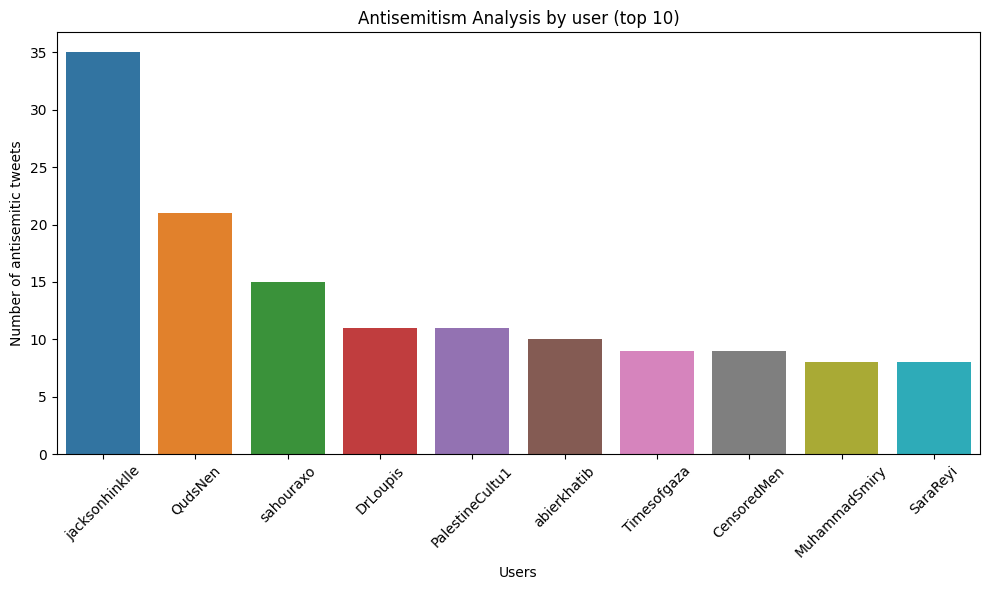

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a color palette for each country
country_palette = sns.color_palette("husl", n_colors=len(top_10_antisemits['user'].unique()))

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_antisemits, x='user', y='test_antisemitic_post', hue=country_palette, legend=False)
plt.title("Antisemitism Analysis by user (top 10)")
plt.xlabel("Users")
plt.ylabel("Number of antisemitic tweets")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
#plt.savefig("hist_by_10users.png")
plt.show()

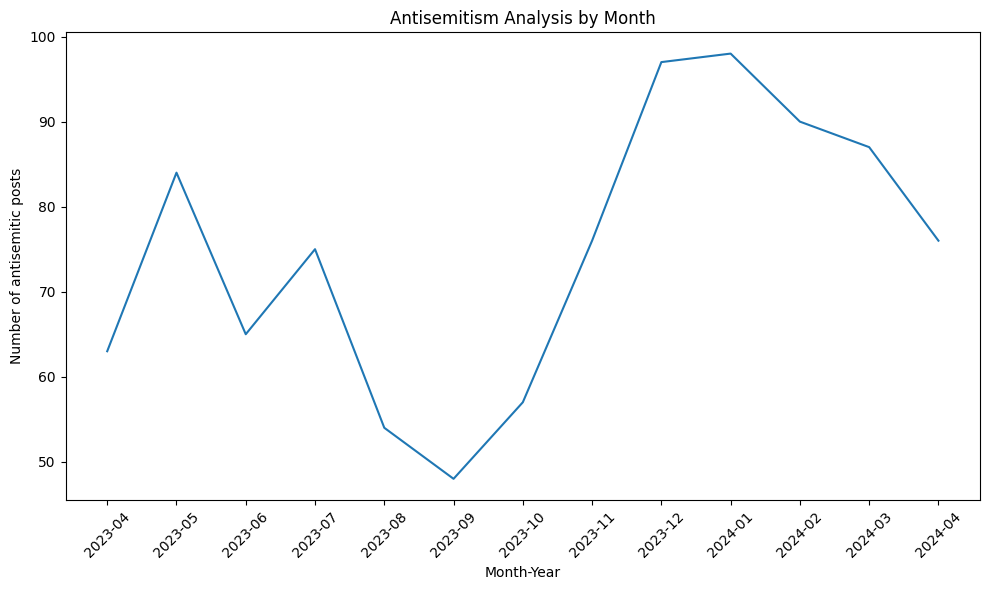

In [ ]:
# create line plot showing number of antisemitic post  for every month_year using chatGPT analysis

import seaborn as sns
import matplotlib.pyplot as plt

# Group by month_year and count the number of antisemitic posts
grouped_df = testing_df.groupby('month_year')['antisemitic_post'].sum().reset_index()

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_df, x='month_year', y='antisemitic_post')
plt.title("Antisemitism Analysis by Month")
plt.xlabel("Month-Year")
plt.ylabel("Number of antisemitic posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



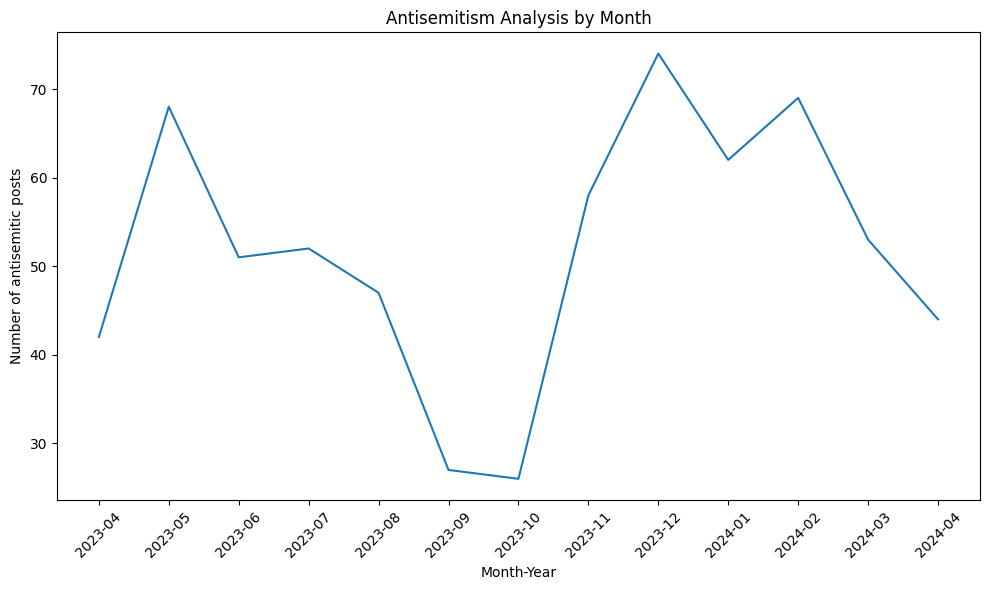

In [ ]:
# create line plot showing number of antisemitic post  for every month_year using our model

import seaborn as sns
import matplotlib.pyplot as plt

# Group by month_year and count the number of antisemitic posts
grouped_df = testing_df.groupby('month_year')['test_antisemitic_post'].sum().reset_index()

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_df, x='month_year', y='test_antisemitic_post')
plt.title("Antisemitism Analysis by Month")
plt.xlabel("Month-Year")
plt.ylabel("Number of antisemitic posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



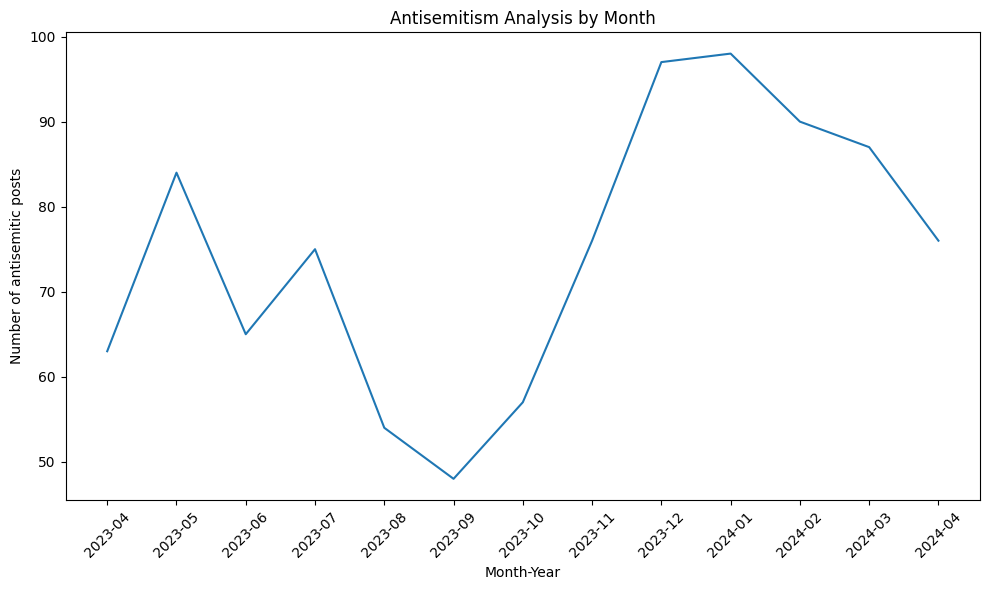

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# Group by month_year and count the number of antisemitic posts
grouped_df = testing_df.groupby('month_year')['antisemitic_post'].sum().reset_index()

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_df, x='month_year', y='antisemitic_post')
plt.title("Antisemitism Analysis by Month")
plt.xlabel("Month-Year")
plt.ylabel("Number of antisemitic posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

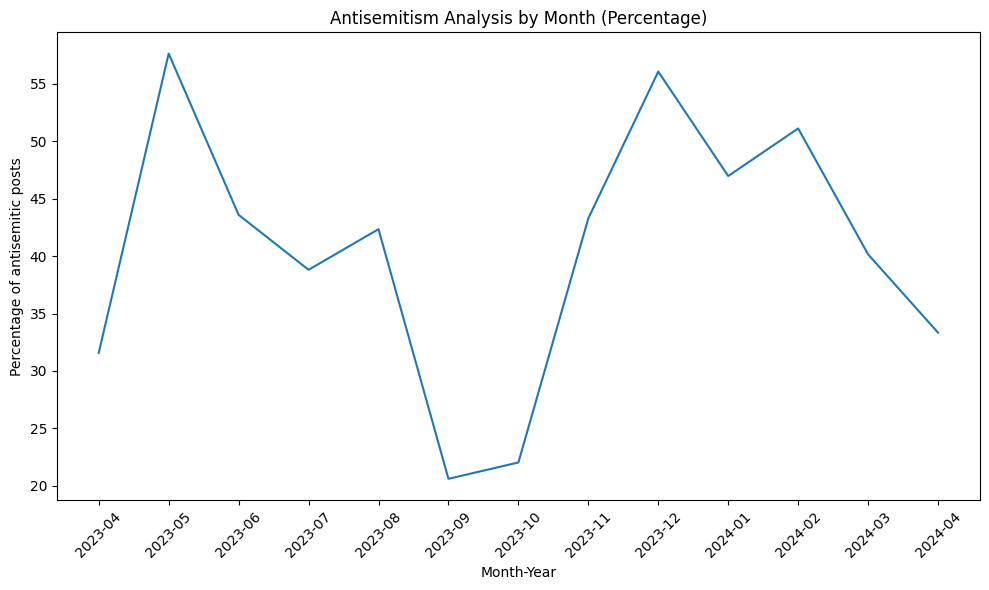

In [ ]:
# create line plot showing Percentage of antisemitic post  for every month_year using our model analysis

# Group by month_year and calculate the percentage of antisemitic posts
grouped_df = testing_df.groupby('month_year')['test_antisemitic_post'].agg(lambda x: x.sum() / len(x) * 100).reset_index()

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_df, x='month_year', y='test_antisemitic_post')
plt.title("Antisemitism Analysis by Month (Percentage)")
plt.xlabel("Month-Year")
plt.ylabel("Percentage of antisemitic posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


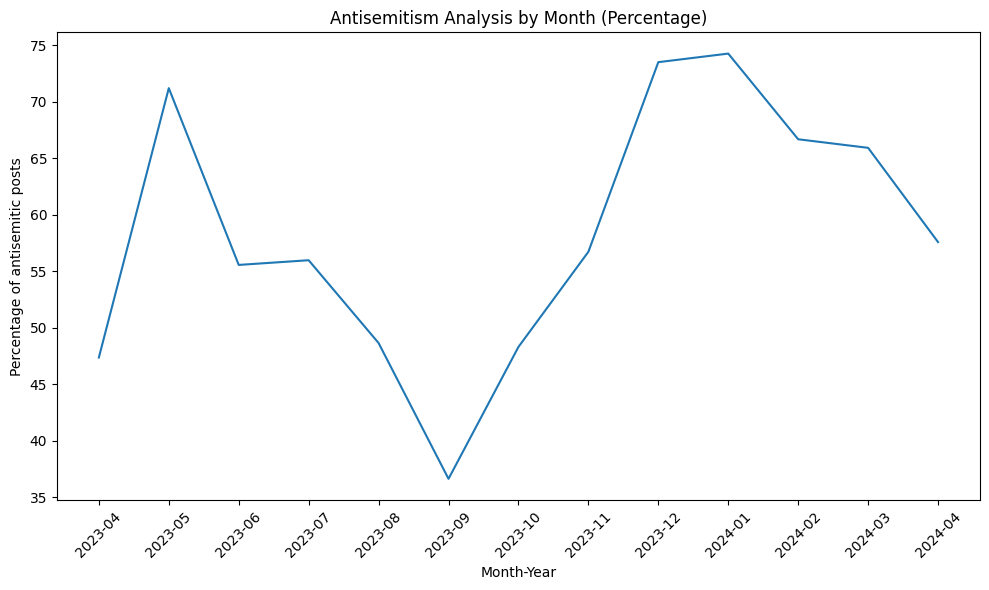

In [ ]:
# create line plot showing Percentage of antisemitic post  for every month_year using ChatGPT analysis

# Group by month_year and calculate the percentage of antisemitic posts
grouped_df = testing_df.groupby('month_year')['antisemitic_post'].agg(lambda x: x.sum() / len(x) * 100).reset_index()

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_df, x='month_year', y='antisemitic_post')
plt.title("Antisemitism Analysis by Month (Percentage)")
plt.xlabel("Month-Year")
plt.ylabel("Percentage of antisemitic posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
